<a href="https://colab.research.google.com/github/RipeNishtala/Ripe/blob/main/FAERS_GAT_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torch-geometric networkx matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
# Define Nodes (Drugs & Proteins)
nodes = {
    "Drug A": 0, "Drug B": 1, "Drug C": 2,  # Drugs
    "Protein X": 3, "Protein Y": 4, "Protein Z": 5  # Proteins
}

# Define Edges (Connections Between Nodes)
edges = torch.tensor([
    [0, 3], [1, 4], [2, 5],  # Drug → Protein
    [3, 4], [4, 5],  # Protein → Protein Interaction
    [0, 1], [1, 2], [0, 2]  # Drug → Drug Interaction
], dtype=torch.long).t()  # Transpose for PyTorch format

# Define Node Features (Random Features for Simplicity)
node_features = torch.rand((len(nodes), 16), dtype=torch.float)  # 16D Features per Node

# Define Labels for Drug Combinations (1 = Side Effect, 0 = No Side Effect)
edge_labels = torch.tensor([1, 0, 1, 0, 1, 1, 0, 1], dtype=torch.float)

# Create PyTorch Geometric Data Object
graph_data = Data(x=node_features, edge_index=edges, y=edge_labels)


In [6]:
class EdgePredictor(torch.nn.Module):
    def __init__(self, edge_input_dim):
        super(EdgePredictor, self).__init__()
        self.fc = torch.nn.Linear(edge_input_dim, 1)  # Single output for binary classification

    def forward(self, edge_embeddings):
        return torch.sigmoid(self.fc(edge_embeddings)).squeeze()  # Apply Sigmoid


In [7]:
hidden_dim = 32  # Hidden layer size in GNN
num_heads = 4  # Multi-head attention for better learning
edge_dim = hidden_dim * 2  # Since edge embeddings concatenate two node embeddings

# Initialize GAT Model
gat_model = DecagonGAT(input_dim=16, hidden_dim=hidden_dim, num_heads=num_heads)
edge_predictor = EdgePredictor(edge_input_dim=edge_dim)  # 64D edge embeddings

# Define Optimizer & Loss Function
optimizer = torch.optim.Adam(list(gat_model.parameters()) + list(edge_predictor.parameters()), lr=0.01)
loss_function = torch.nn.BCELoss()  # Binary Cross-Entropy for Classification


In [8]:
# Training Loop
for epoch in range(200):
    optimizer.zero_grad()

    # Get node embeddings from GAT
    node_embeddings = gat_model(graph_data.x, graph_data.edge_index)

    # Create edge embeddings by concatenating node representations
    edge_embeddings = torch.cat([node_embeddings[graph_data.edge_index[0]],
                                 node_embeddings[graph_data.edge_index[1]]], dim=1)

    # Get predictions
    output = edge_predictor(edge_embeddings)  # Final prediction

    # Compute loss
    loss = loss_function(output, graph_data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.6847
Epoch 20: Loss = 0.3120
Epoch 40: Loss = 0.2850
Epoch 60: Loss = 0.2824
Epoch 80: Loss = 0.2812
Epoch 100: Loss = 0.2812
Epoch 120: Loss = 0.2812
Epoch 140: Loss = 0.2812
Epoch 160: Loss = 0.2812
Epoch 180: Loss = 0.2812


In [9]:
# Get predictions
with torch.no_grad():
    node_embeddings = gat_model(graph_data.x, graph_data.edge_index)
    edge_embeddings = torch.cat([node_embeddings[graph_data.edge_index[0]],
                                 node_embeddings[graph_data.edge_index[1]]], dim=1)
    predictions = edge_predictor(edge_embeddings).detach().numpy()
    predicted_labels = (predictions > 0.5).astype(int)

# Print Predictions
for i, (drug_pair, label) in enumerate(zip(graph_data.edge_index.t(), predicted_labels)):
    node1, node2 = list(nodes.keys())[drug_pair[0]], list(nodes.keys())[drug_pair[1]]
    print(f"Interaction: {node1} ↔ {node2} | Predicted Side Effect: {'Yes' if label == 1 else 'No'}")


Interaction: Drug A ↔ Protein X | Predicted Side Effect: Yes
Interaction: Drug B ↔ Protein Y | Predicted Side Effect: No
Interaction: Drug C ↔ Protein Z | Predicted Side Effect: Yes
Interaction: Protein X ↔ Protein Y | Predicted Side Effect: No
Interaction: Protein Y ↔ Protein Z | Predicted Side Effect: Yes
Interaction: Drug A ↔ Drug B | Predicted Side Effect: Yes
Interaction: Drug B ↔ Drug C | Predicted Side Effect: Yes
Interaction: Drug A ↔ Drug C | Predicted Side Effect: Yes


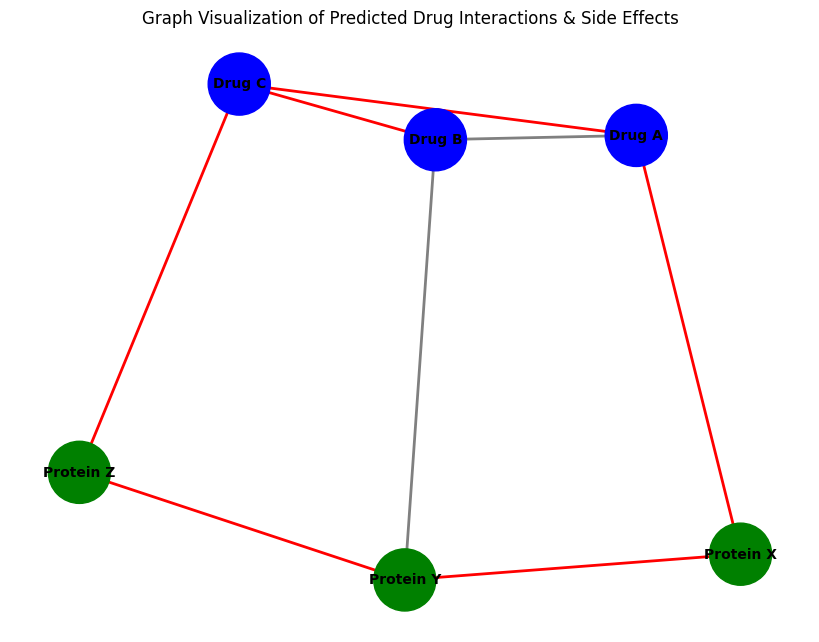

In [10]:
# Create a NetworkX graph for visualization
G = nx.Graph()

# Add nodes with labels
for node, idx in nodes.items():
    G.add_node(node, color='blue' if 'Drug' in node else 'green')

# Add edges with predicted labels (Red if Side Effect is predicted, Gray otherwise)
edge_colors = []
for i, (node1_idx, node2_idx) in enumerate(graph_data.edge_index.t().numpy()):
    node1, node2 = list(nodes.keys())[node1_idx], list(nodes.keys())[node2_idx]
    G.add_edge(node1, node2)
    edge_colors.append('red' if predicted_labels[i] == 1 else 'gray')

# Define node colors
node_colors = [G.nodes[n]['color'] for n in G.nodes]

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout for better visualization

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        node_size=2000, font_size=10, font_weight='bold', width=2)

plt.title("Graph Visualization of Predicted Drug Interactions & Side Effects")
plt.show()


In [1]:
from google.colab import files

uploaded = files.upload()


Saving report_chunk_35.csv to report_chunk_35.csv


In [15]:
pip install torch torch-geometric pandas networkx matplotlib


In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [19]:
# Load FAERS dataset (replace 'faers_data.csv' with your file name)
file_path = "report_chunk_35.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Show first few rows
print(df.head())

# Use a small subset of the dataset (500 drug interactions)
df = df.sample(n=500, random_state=42)


     caseid  primaryid  caseversion    fda_dt i_f_cod  event_dt   age gender  \
0  19790948  197909481            1  20210906       I       NaN  67.0      M   
1  19790948  197909481            1  20210906       I       NaN  67.0      M   
2  19790948  197909481            1  20210906       I       NaN  67.0      M   
3  19790948  197909481            1  20210906       I       NaN  67.0      M   
4  19790948  197909481            1  20210906       I       NaN  67.0      M   

  country_code period adverse_event   drug_id  drug_seq role_cod     rxaui  \
0           CN   21Q3   Tachycardia  64355375         5       SS  12252786   
1           CN   21Q3   Tachycardia  64355376         6       SS  12253412   
2           CN   21Q3   Tachycardia  64355377         7        C  11794216   
3           CN   21Q3   Tachycardia  64355371         1       PS  12253897   
4           CN   21Q3   Tachycardia  64355371         1       PS  12254008   

                      drug  
0                 pro

In [7]:
df = df[['primaryid', 'drug', 'adverse_event']].dropna()


In [ ]:
# Create a mapping for drugs and adverse events
drug_to_id = {drug: idx for idx, drug in enumerate(df['drug'].unique())}
event_to_id = {event: idx + len(drug_to_id) for idx, event in enumerate(df['adverse_event'].unique())}

# Calculate total nodes
num_drugs = len(drug_to_id)
num_events = len(event_to_id)
total_nodes = num_drugs + num_events

# Create edges (drug → side effect connections)
edges = []
for _, row in df.iterrows():
    drug_id = drug_to_id[row['drug']]
    event_id = event_to_id[row['adverse_event']]
    edges.append((drug_id, event_id))  # Drug → Side Effect edge

# Convert edges to PyTorch Geometric format
edge_index = torch.tensor(edges, dtype=torch.long).t()

# Generate random node features (16-dimensional for both drugs and side effects)
node_features = torch.rand((total_nodes, 16), dtype=torch.float)

# Create PyTorch Geometric Data Object
graph_data = Data(x=node_features, edge_index=edge_index)

# Print graph information
print(f"✅ Graph Created: {graph_data.x.shape[0]} nodes, {graph_data.edge_index.shape[1]} edges")


In [20]:
class FAERSGAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(FAERSGAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x


In [21]:
class EdgePredictor(torch.nn.Module):
    def __init__(self, edge_input_dim):
        super(EdgePredictor, self).__init__()
        self.fc = torch.nn.Linear(edge_input_dim, 1)

    def forward(self, edge_embeddings):
        return torch.sigmoid(self.fc(edge_embeddings)).squeeze()


In [22]:
hidden_dim = 32
num_heads = 4
edge_dim = hidden_dim * 2  # Since edge embeddings are concatenations of two node embeddings

# Initialize GAT Model and Edge Predictor
gat_model = FAERSGAT(input_dim=16, hidden_dim=hidden_dim, num_heads=num_heads)
edge_predictor = EdgePredictor(edge_input_dim=edge_dim)

# Define Optimizer & Loss Function
optimizer = torch.optim.Adam(list(gat_model.parameters()) + list(edge_predictor.parameters()), lr=0.01)
loss_function = torch.nn.BCELoss()  # Binary Cross-Entropy for classification


In [23]:
# Training Loop
for epoch in range(10):  # Reduce epochs for simplicity
    optimizer.zero_grad()

    # Get node embeddings from the GAT model
    node_embeddings = gat_model(graph_data.x, graph_data.edge_index)

    # Create edge embeddings by concatenating node embeddings
    edge_embeddings = torch.cat([
        node_embeddings[graph_data.edge_index[0]],
        node_embeddings[graph_data.edge_index[1]]
    ], dim=1)

    # Get predictions
    output = edge_predictor(edge_embeddings)

    # Create dummy labels (assuming all edges represent interactions)
    labels = torch.ones(output.shape)  # Binary label (1 for all interactions)

    # Compute loss
    loss = loss_function(output, labels)
    loss.backward()
    optimizer.step()

    print(f"✅ Epoch {epoch + 1}: Loss = {loss.item():.4f}")


✅ Epoch 1: Loss = 0.7177
✅ Epoch 2: Loss = 0.2024
✅ Epoch 3: Loss = 0.0384
✅ Epoch 4: Loss = 0.0056
✅ Epoch 5: Loss = 0.0008
✅ Epoch 6: Loss = 0.0001
✅ Epoch 7: Loss = 0.0000
✅ Epoch 8: Loss = 0.0000
✅ Epoch 9: Loss = 0.0000
✅ Epoch 10: Loss = 0.0000


In [24]:
with torch.no_grad():
    node_embeddings = gat_model(graph_data.x, graph_data.edge_index)
    edge_embeddings = torch.cat([
        node_embeddings[graph_data.edge_index[0]],
        node_embeddings[graph_data.edge_index[1]]
    ], dim=1)
    predictions = edge_predictor(edge_embeddings).detach().numpy()
    predicted_labels = (predictions > 0.5).astype(int)

# Print Predictions
for i, (drug_idx, event_idx) in enumerate(graph_data.edge_index.t().numpy()):
    drug = list(drug_to_id.keys())[drug_idx]
    event = list(event_to_id.keys())[event_idx - num_drugs]
    label = "Side Effect" if predicted_labels[i] == 1 else "No Effect"
    print(f"Drug: {drug} ↔ Adverse Event: {event} | Predicted: {label}")


Drug: vitamin B12 ↔ Adverse Event: Dysuria | Predicted: Side Effect
Drug: tocilizumab ↔ Adverse Event: Pericarditis | Predicted: Side Effect
Drug: pantoprazole ↔ Adverse Event: Renal cancer | Predicted: Side Effect
Drug: etanercept ↔ Adverse Event: Oxygen saturation decreased | Predicted: Side Effect
Drug: etanercept ↔ Adverse Event: Malignant melanoma | Predicted: Side Effect
Drug: phthalylsulfathiazole ↔ Adverse Event: Malignant melanoma | Predicted: Side Effect
Drug: tofacitinib ↔ Adverse Event: Tachycardia | Predicted: Side Effect
Drug: tofacitinib ↔ Adverse Event: Malignant melanoma | Predicted: Side Effect
Drug: tofacitinib ↔ Adverse Event: Foaming at mouth | Predicted: Side Effect
Drug: golimumab ↔ Adverse Event: Malignant melanoma | Predicted: Side Effect
Drug: golimumab ↔ Adverse Event: Foaming at mouth | Predicted: Side Effect
Drug: infliximab ↔ Adverse Event: Foaming at mouth | Predicted: Side Effect
Drug: ergocalciferol ↔ Adverse Event: Hypoaesthesia | Predicted: Side Effec

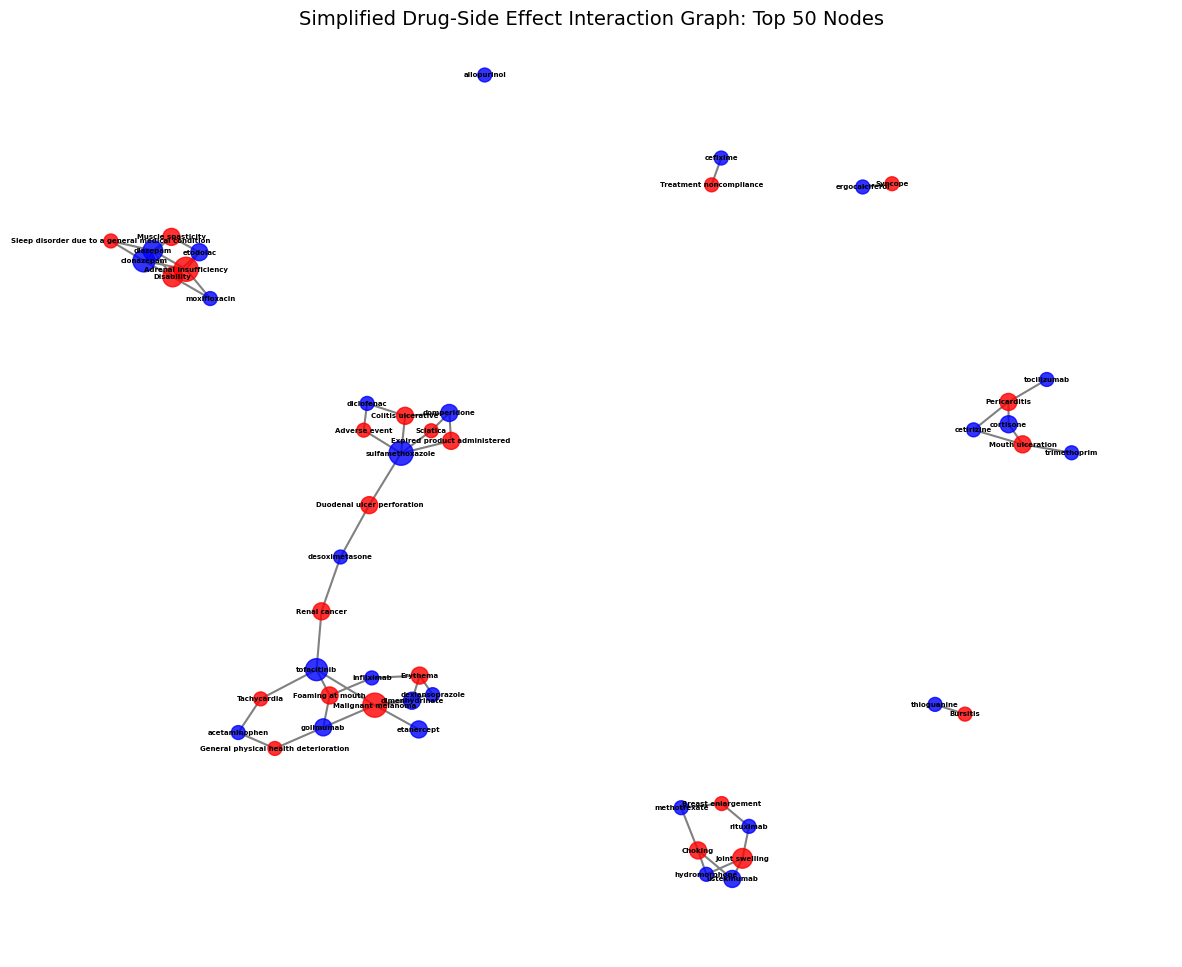

In [27]:
# Filter for the top 50 most connected nodes
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:50]  # Top 50 nodes
subgraph = G.subgraph(top_nodes)  # Create a subgraph with only these nodes

# Define Node Colors: Blue for drugs, Red for side effects
node_colors = ['blue' if node in drug_to_id else 'red' for node in subgraph.nodes()]

# Define Node Sizes: Scale based on degree
node_sizes = [degree_dict[node] * 50 for node in subgraph.nodes()]  # Multiply by 50 for visibility

# Draw the Graph
plt.figure(figsize=(15, 12))  # Larger figure for better spacing
pos = nx.spring_layout(subgraph, seed=42)  # Layout for clarity

# Draw edges
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', width=1.5)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=5, font_weight='bold')

# Add title
plt.title("Simplified Drug-Side Effect Interaction Graph: Top 50 Nodes", fontsize=14)
plt.axis("off")
plt.show()
